# Imports

In [15]:
import os
import json

from transformers import AutoTokenizer, BertTokenizerFast, DataCollatorForTokenClassification
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
import tokenizers

import matplotlib.pyplot as plt
from sklearn import preprocessing

from utils.dataset import POSFolderDataSet


# Utility Functions

In [16]:
VOCAB_FOLDER = 'data/vocab'
TOKENIZER_PATH = os.path.join('models', 'tokenizers')
NAME = 'gnlp-tokenizer'

In [17]:
def get_corpus(dataset):
    for data in dataset:
        for sentence in data['data'].mod_words:
            yield " ".join(sentence)

In [18]:
with open(os.path.join(VOCAB_FOLDER, 'freq.json'), 'r') as f:
    freq_counts = json.load(f)

In [4]:
def evaluate(tokenizer, thresh: int = 10):
    total_mean = 0
    less_freq_mean = 0
    less_freq_count = 0
    freq_adj_mean = 0
    freq_count = 0
    for word, freq in freq_counts.items():
        num_tokens = len(tokenizer.tokenize(word))
        total_mean += num_tokens
        freq_adj_mean += num_tokens * freq
        freq_count += freq
        if freq <= thresh:
            less_freq_count += 1
            less_freq_mean += num_tokens

    return less_freq_mean / len(freq_counts), less_freq_mean / less_freq_count, freq_adj_mean / freq_count

# Tokenizer Training

In [35]:
dataset = POSFolderDataSet('data')

## Training from pretrained model

In [107]:
old_tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [108]:
old_tokenizer.tokenize('არ მინდა-მეთქი')

['არ', 'მ', '##ინ', '##და', '-', 'მე', '##თ', '##ქი']

In [205]:
sizes = [10, 100, 1000, 5000, 6000, 7000, 8000, 9000, 10000, 15000]
results = [None] * len(sizes)
tokenizers = [None] * len(sizes)
for idx, size in enumerate(sizes):
    tokenizers[idx] = old_tokenizer.train_new_from_iterator(get_corpus(dataset), size)
    results[idx] = evaluate(tokenizers[idx])

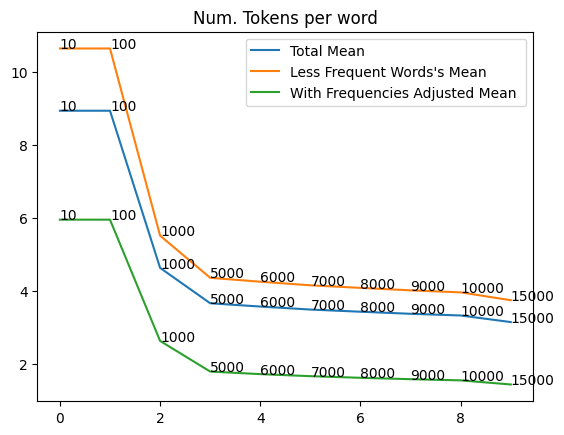

In [206]:
fig, ax = plt.subplots()
total_means = [r[0] for r in results]
less_freq_means = [r[1] for r in results]
adjusted_means = [r[2] for r in results]

plt.title('Num. Tokens per word')

ax.plot(total_means, label='Total Mean')
for i, txt in enumerate(sizes):
    ax.annotate(txt, (i, total_means[i]))

ax.plot(less_freq_means, label='Less Frequent Words\'s Mean')
for i, txt in enumerate(sizes):
    ax.annotate(txt, (i, less_freq_means[i]))
    
ax.plot(adjusted_means, label='With Frequencies Adjusted Mean ')
for i, txt in enumerate(sizes):
    ax.annotate(txt, (i, adjusted_means[i]))
ax.legend()

In [212]:
print(total_means[2:-1], less_freq_means[2:-1], adjusted_means[2:-1], sep='\n')

[4.62328401725863, 3.652318407136877, 3.5622680313599284, 3.479888339319562, 3.420224562518985, 3.363439945911636, 3.317099565921282]
[5.507017878309225, 4.3504536364838895, 4.243190265360484, 4.145063817756925, 4.0739953987928965, 4.006356487209215, 3.951158212532194]
[2.6188994758860047, 1.7792648265334048, 1.708810509790335, 1.6525564883164017, 1.6079001961723631, 1.5699229129683114, 1.5372528641093754]


In [213]:
tokenizer = tokenizers[4]

In [214]:
tokenizer.tokenize('არა-მეთქი')

['არა', '-', 'მეთქი']

In [215]:
tokenizer.tokenize('კი-თქო')

['კი', '-', 'თქ', '##ო']

In [216]:
tokenizer.tokenize('კარი'), tokenizer.tokenize('კარმა'), tokenizer.tokenize('კარს')

(['კარი'], ['კარ', '##მა'], ['კარ', '##ს'])

In [217]:
tokenizer.tokenize('კარის'), tokenizer.tokenize('კარით'), tokenizer.tokenize('კარად'), tokenizer.tokenize('კარო')

(['კარი', '##ს'], ['კარი', '##თ'], ['კარ', '##ად'], ['კარ', '##ო'])

In [218]:
tokenizer.tokenize('კარი'), tokenizer.tokenize('კარები')

(['კარი'], ['კარ', '##ები'])

In [229]:
tokenizer('მე მივდივარ სახლში').tokens()

['[CLS]', 'მე', 'მივდივარ', 'სახლში', '[SEP]']

ახალი ამბებია ხშირად კორპუსში, როგორც ჩანს

In [224]:
max(tokenizer.vocab.keys(), key=lambda x: len(x))

'გასათვალისწინებელია'

In [328]:
VERB = ['ვკონცენტრირდები', 'კონცენტრირდები', 'კონცენტრირდება', 'მივქრი', 'მივქროდე', 'მივქროდი', 'მივიქროლებდი', 'ვმესიჯობთ', 'ვიმესიჯებთ']
COMPOSITES = ['მთა-ბარი', 'ერთ-ერთი', 'ღარიბ-ღატაკი', 'სახნავ-სათესი', 'მიწერ-მოწერა', 'ქართლ-კახეთ-იმერეთი', 'სახნავ-სათესი']
NOUNS = ['კარი', 'კარმა', 'კარს', 'კარის', 'კარით', 'კარად', 'კარო', 'ჰიდროელექტროსადგური', 'ჰიდროელექტროსადგურმა', 'ჰიდროელექტროსადგურს', 'ჰიდროელექტროსადგურის', 'ჰიდროელექტროსადგურად', 'ჰიდროელექტროსადგურით', 'ჰიდროელექტროსადგურო', 'კივი', 'კივიმ', 'კივის', 'კივით', 'კივად', 'კივო']
FORMS = ['ვჭამ', 'ჭამა', 'საჭმელი', 'ნაჭამი', 'ვჭრი', 'მოვჭერი', 'მოჭრილი', 'ჭრა', 'ქალაქი', 'ნაქალაქარი']
SING_PLUR = ['ფიცარი', 'ფიცრები', 'ფიცარნი', 'მთა', 'მთები', 'მთანი', 'ტელეფონი', 'ტელეფონები', 'ტელეფონნი', 'სოფელი', 'სოფლები', 'სოფელნი']
ADJ = ['ლამაზი', 'გამოხმაურებადი', 'ნატვრადი', 'ნამდვილი', 'დამტკბარი', 'დამსახურებული']


## Save tokenizers

In [4]:
for idx, tokenizer in enumerate(tokenizers):
    tokenizer.save_pretrained(os.path.join(TOKENIZER_PATH, f'{NAME}_{sizes[idx]}'))
    

NameError: name 'tokenizers' is not defined

## Different Algorithms

### Wordpiece

In [19]:
WORDPIECE_TOKENIZER_PATH = os.path.join(TOKENIZER_PATH, 'wordpiece_tokenizer')

In [20]:
UNK_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'
CLS_TOKEN = '<CLS>'
SEP_TOKEN = '<SEP>'
MASK_TOKEN = '<MASK>'
SPECIAL_TOKENS = [UNK_TOKEN, PAD_TOKEN, CLS_TOKEN, SEP_TOKEN, MASK_TOKEN]

wordpiece_tokenizer = Tokenizer(models.WordPiece(unk_token=UNK_TOKEN))

In [21]:
wordpiece_tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.StripAccents()]
)

In [13]:
print(wordpiece_tokenizer.normalizer.normalize_str("უ̈რემია ა̈ლბათ"))

ურემია ალბათ


In [30]:
puncts = tokenizers.Regex('[…?!.,"„“\';:()`~_‘$%/\\=+*|”]')
wordpiece_tokenizer.pre_tokenizer = pre_tokenizers.Sequence(
    [pre_tokenizers.WhitespaceSplit(), pre_tokenizers.Split(puncts, 'isolated')]
)

In [32]:
wordpiece_tokenizer.decoder = decoders.WordPiece(prefix="##")

In [33]:
trainer = trainers.WordPieceTrainer(vocab_size=6000, special_tokens=SPECIAL_TOKENS)

In [36]:
wordpiece_tokenizer.train_from_iterator(get_corpus(dataset), trainer=trainer)

In [37]:
evaluate(wordpiece_tokenizer.model)

NameError: name 'freq_counts' is not defined

In [38]:
cls_token_id = wordpiece_tokenizer.token_to_id(CLS_TOKEN)
sep_token_id = wordpiece_tokenizer.token_to_id(SEP_TOKEN)
cls_token_id, sep_token_id

(2, 3)

In [39]:
wordpiece_tokenizer.post_processor = processors.TemplateProcessing(
    single=f"{CLS_TOKEN}:0 $A:0 {SEP_TOKEN}:0",
    pair=f"{CLS_TOKEN}:0 $A:0 {SEP_TOKEN}:0 $B:1 {SEP_TOKEN}:1",
    special_tokens=[(CLS_TOKEN, cls_token_id), (SEP_TOKEN, sep_token_id)],
)

In [43]:
wordpiece_tokenizer.encode('მე ვმესიჯობ ხშირ-ხშირად').tokens

['<CLS>',
 'მე',
 'ვმ',
 '##ესი',
 '##ჯობ',
 'ხში',
 '##რ',
 '##-',
 '##ხ',
 '##ში',
 '##რად',
 '<SEP>']

In [44]:
wordpiece_tokenizer.save(os.path.join(WORDPIECE_TOKENIZER_PATH, f'wordpiece_6000.json'))    

### BPE

In [261]:
bpe_tokenizer = Tokenizer(models.BPE(unk_token=UNK_TOKEN))
bpe_tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.StripAccents()]
)
bpe_tokenizer.pre_tokenizer = pre_tokenizers.Sequence(
    [pre_tokenizers.WhitespaceSplit(), pre_tokenizers.Punctuation()]
)
trainer = trainers.BpeTrainer(vocab_size=6000, special_tokens=SPECIAL_TOKENS)

In [263]:
bpe_tokenizer.train_from_iterator(get_corpus(dataset), trainer=trainer)

In [265]:
bpe_tokenizer.encode('არა-მეთქი').tokens

['არა', '-', 'მეთქი']

In [289]:
evaluate(bpe_tokenizer.model)

(3.3930045498243326, 4.041572321171518, 1.656718635085821)

# Data Preparation

In [7]:
from datasets import load_dataset

In [8]:
TRAIN_PATH = os.path.join('data', 'train')
TEST_PATH = os.path.join('data', 'test')
TOKENIZED_DATASET_PATH = os.path.join('data', 'dataset', 'tokenized')

In [9]:
LABELS = ['A', 'Adv', 'Cj', 'Interj', 'N', 'Num', 'Other', 'Pp', 'Pron', 'Punct', 'V']
LABELS

['A', 'Adv', 'Cj', 'Interj', 'N', 'Num', 'Other', 'Pp', 'Pron', 'Punct', 'V']

In [10]:
le = preprocessing.LabelEncoder()
le.fit_transform(LABELS)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [233]:
dataset = load_dataset('parquet', data_files={'train': [os.path.join(TRAIN_PATH, f'train_upd_{i}.parquet') for i in range(1, 10)],
                                    'test': [os.path.join(TEST_PATH, f'test_upd_{i}.parquet') for i in range(1, 10)]})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [234]:
dataset

DatasetDict({
    train: Dataset({
        features: ['init_words', 'mod_words', 'pos_tags', 'sentence_length', 'unique_pos', 'starts_with'],
        num_rows: 5678203
    })
    test: Dataset({
        features: ['init_words', 'mod_words', 'pos_tags', 'sentence_length', 'unique_pos', 'starts_with'],
        num_rows: 2433521
    })
})

In [235]:
tokenizer = Tokenizer.from_file(os.path.join(WORDPIECE_TOKENIZER_PATH, 'wordpiece_6000.json'))
tokenizer = BertTokenizerFast(tokenizer_object=tokenizer, unk_token=UNK_TOKEN,
    pad_token=PAD_TOKEN,
    cls_token=CLS_TOKEN,
    sep_token=SEP_TOKEN,
    mask_token=MASK_TOKEN, model_input_names=['input_ids', 'attention_mask'])

In [236]:
tokenizer('მივდი-მოვდივარ სახლში').tokens()

['<CLS>', 'მივ', '##დი', '##-მ', '##ოვ', '##დი', '##ვარ', 'სახლში', '<SEP>']

In [237]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # special token
            new_labels.append(-100)
        else:
            # same word as previous token
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

In [238]:
tokens = tokenizer(dataset['train'][0]['mod_words'], truncation=True, is_split_into_words=True)
labels = le.transform(dataset['train'][0]['pos_tags'])
print(tokens.word_ids(), labels, sep='\n')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 5, 5, 5, 6, None]
[10  8  8  0  2  0  9]


In [239]:
print(tokens.tokens(),align_labels_with_tokens(labels, tokens.word_ids()), sep='\n')

['<CLS>', 'არის', 'ამაში', 'რაღაც', 'ძ', '##ლევა', '##მოს', '##ილი', 'და', 'ამაღ', '##ელ', '##ვებ', '##ელი', '.', '<SEP>']
[-100, 10, 8, 8, 0, 0, 0, 0, 2, 0, 0, 0, 0, 9, -100]


In [240]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["mod_words"], truncation=True, is_split_into_words=True
    )
    all_labels = [le.transform(tags) for tags in examples["pos_tags"]]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs


In [241]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/5678203 [00:00<?, ? examples/s]

Map:   0%|          | 0/2433521 [00:00<?, ? examples/s]

In [242]:
train_size = int(0.8 * len(tokenized_datasets['train']))  # Adjust the split ratio as needed
train_dataset = tokenized_datasets['train'].select(range(train_size))
eval_dataset = tokenized_datasets['train'].select(range(train_size, len(tokenized_datasets['train'])))
tokenized_datasets['train'] = train_dataset
tokenized_datasets['val'] = eval_dataset
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4542562
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2433521
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1135641
    })
})

In [243]:
tokenized_datasets.save_to_disk(TOKENIZED_DATASET_PATH)

Saving the dataset (0/4 shards):   0%|          | 0/4542562 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/2433521 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1135641 [00:00<?, ? examples/s]

# Model

In [22]:
from transformers import DistilBertConfig, DistilBertForTokenClassification
from datasets import load_from_disk
import evaluate
import numpy as np

In [23]:
tokenized_datasets = load_from_disk(TOKENIZED_DATASET_PATH)

NameError: name 'TOKENIZED_DATASET_PATH' is not defined

In [24]:
train_size = int(0.9 * len(tokenized_datasets['train']))  # Adjust the split ratio as needed
train_dataset = tokenized_datasets['train'].select(range(train_size))
eval_dataset = tokenized_datasets['train'].select(range(train_size, len(tokenized_datasets['train'])))
tokenized_datasets['train'] = train_dataset
tokenized_datasets['val'] = eval_dataset
tokenized_datasets

NameError: name 'tokenized_datasets' is not defined

In [25]:
tokenizer = Tokenizer.from_file(os.path.join(WORDPIECE_TOKENIZER_PATH, 'wordpiece_6000.json'))
tokenizer = BertTokenizerFast(tokenizer_object=tokenizer, unk_token=UNK_TOKEN,
    pad_token=PAD_TOKEN,
    cls_token=CLS_TOKEN,
    sep_token=SEP_TOKEN,
    mask_token=MASK_TOKEN, model_input_names=['input_ids', 'attention_mask'])

In [36]:
tokenizer.save_pretrained('postagger-tokenizer')

('postagger-tokenizer/tokenizer_config.json',
 'postagger-tokenizer/special_tokens_map.json',
 'postagger-tokenizer/vocab.txt',
 'postagger-tokenizer/added_tokens.json',
 'postagger-tokenizer/tokenizer.json')

In [15]:
tokenizer('მე მივდივარ')

{'input_ids': [2, 199, 1827, 277, 322, 3], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [16]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [36]:
from sklearn.metrics import classification_report
metric = evaluate.load("seqeval")


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[LABELS[l] for l in label if l != -100] for label in labels ]
    true_predictions = [
        [LABELS[p]  for (p, l) in zip(prediction, label) if l != -100 ]
        for prediction, label in zip(predictions, labels)
    ]
    # print(true_predictions[:2], true_labels[:2])
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    # print(classification_report(true_labels, true_predictions, output_dict=True))
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [18]:
id2label = {i: label for i, label in zip(le.transform(LABELS), LABELS)}
label2id = {v: str(k) for k, v in id2label.items()}

In [64]:
config = DistilBertConfig(vocab_size=tokenizer.vocab_size, pad_token_id=tokenizer.pad_token_id, 
                 hidden_dim=128, n_layers=1, n_heads=1, dim=128,
                          max_position_embeddings=200, n_classes = len(LABELS), id2label=id2label, label2id=label2id)
config

DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 128,
  "dropout": 0.1,
  "hidden_dim": 128,
  "id2label": {
    "0": "A",
    "1": "Adv",
    "2": "Cj",
    "3": "Interj",
    "4": "N",
    "5": "Num",
    "6": "Other",
    "7": "Pp",
    "8": "Pron",
    "9": "Punct",
    "10": "V"
  },
  "initializer_range": 0.02,
  "label2id": {
    "A": "0",
    "Adv": "1",
    "Cj": "2",
    "Interj": "3",
    "N": "4",
    "Num": "5",
    "Other": "6",
    "Pp": "7",
    "Pron": "8",
    "Punct": "9",
    "V": "10"
  },
  "max_position_embeddings": 200,
  "model_type": "distilbert",
  "n_classes": 11,
  "n_heads": 1,
  "n_layers": 1,
  "pad_token_id": 1,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.31.0",
  "vocab_size": 6000
}

In [26]:
# model = DistilBertForTokenClassification(config=config)
# model = DistilBertForTokenClassification.from_pretrained('models/results/checkpoint-31944')
model = DistilBertForTokenClassification.from_pretrained('models/transformer_f')
print('Number of parameters: ', sum(p.numel() for p in model.parameters()))

Number of parameters:  431115


In [67]:
import transformers
transformers.logging.set_verbosity_info()

In [68]:
from transformers import TrainingArguments
# TrainingArguments = None

args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1.2e-2,
    logging_steps=10,
    per_device_train_batch_size=1024,
    per_device_eval_batch_size=1024,
    num_train_epochs=4,
    weight_decay=0.01,
    output_dir='./models/results',
save_safetensors=True, 
save_steps=100)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [69]:
from transformers import Trainer
import torch
import torch.nn as nn
   # "0": "A",
   #  "1": "Adv",
   #  "2": "Cj",
   #  "3": "Interj",
   #  "4": "N",
   #  "5": "Num",
   #  "6": "Other",
   #  "7": "Pp",
   #  "8": "Pron",
   #  "9": "Punct",
   #  "10": "V"
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.13, 0.13, 0.1, 0.13, 0.08, 0.08, 0.01, 0.09, 0.09, 0.06, 0.1]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [70]:

trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4,088,832
  Num Epochs = 4
  Instantaneous batch size per device = 1,024
  Total train batch size (w. parallel, distributed & accumulation) = 1,024
  Gradient Accumulation steps = 1
  Total optimization steps = 15,972
  Number of trainable parameters = 894,859


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.541500,0.564821,0.846096,0.888470,0.866765,0.799023
2,0.527000,0.551087,0.841806,0.889162,0.864836,0.807457
3,0.515500,0.536890,0.857452,0.892620,0.874683,0.812341


***** Running Evaluation *****
  Num examples = 454656
  Batch size = 1024
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Pron seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: N seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: V seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Punct seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Adv seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/

In [44]:
print('Done')

Done


In [31]:
num_parts = 30
part_size = tokenized_datasets["test"].num_rows // num_parts
part_size

81117

In [35]:
results = []
for idx in range(num_parts):
    results.append(trainer.evaluate(tokenized_datasets["test"].select(range(idx * part_size, (idx+1)*part_size))))

***** Running Evaluation *****
  Num examples = 81920
  Batch size = 1024


{'A': {'precision': 0.8463544523871818, 'recall': 0.8899716009939652, 'f1-score': 0.867615187288843, 'support': 225360.0}, 'Adv': {'precision': 0.9119944176818247, 'recall': 0.9115422751794027, 'f1-score': 0.911768290376671, 'support': 119006.0}, 'Cj': {'precision': 0.9767434804375199, 'recall': 0.9846756186339584, 'f1-score': 0.9806935104300739, 'support': 65386.0}, 'Interj': {'precision': 0.8802970729576234, 'recall': 0.8388842631140716, 'f1-score': 0.8590918780643786, 'support': 2402.0}, 'N': {'precision': 0.9506787010672288, 'recall': 0.9347659698948632, 'f1-score': 0.9426551855356607, 'support': 748643.0}, 'Num': {'precision': 0.9621770501978432, 'recall': 0.9709532198081816, 'f1-score': 0.9665452136469029, 'support': 25545.0}, 'Other': {'precision': 1.0, 'recall': 0.13662551440329218, 'f1-score': 0.24040550325850832, 'support': 6075.0}, 'Pp': {'precision': 0.9306046511627907, 'recall': 0.9499572690152882, 'f1-score': 0.9401813824538321, 'support': 10531.0}, 'Pron': {'precision': 

TypeError: 'NoneType' object does not support item assignment

In [270]:
import functools
functools.reduce(lambda a, b: {'eval_loss': a['eval_loss'] + b['eval_loss'] / num_parts, 
                               'eval_precision': a['eval_precision']  + b['eval_precision'] / num_parts,
                               'eval_recall': a['eval_recall']  + b['eval_recall'] / num_parts,
                               'eval_f1': a['eval_f1']  + b['eval_f1'] / num_parts,
                               'eval_accuracy': a['eval_accuracy'] + b['eval_accuracy'] / num_parts
                              }, results, {'eval_loss': 0, 
                               'eval_precision': 0,
                               'eval_recall': 0,
                               'eval_f1': 0,
                               'eval_accuracy': 0
                              })

{'eval_loss': 0.10056926406919957,
 'eval_precision': 0.9660170914840222,
 'eval_recall': 0.9753977932199065,
 'eval_f1': 0.9706834926152136,
 'eval_accuracy': 0.9671524699232752}

In [99]:
tokenizer.batch_decode(tokenized_datasets['train'][0:10]['input_ids'])

['<CLS> არის ამაში რაღაც ძლევამოსილი და ამაღელვებელი. <SEP>',
 '<CLS> ელიეზერმა დაწვრილებით უამბო, თუ რისთვის არის გამოგზავნილი და როგორ უჩვენა უფალმა რებეკა, როგორც მისგან არჩეული საცოლე ისაკისათვის ; ბოლოს ჰკითხა : თანახმანი ხართ, გამოუშვათ ჩემთა რებეკა, რათა გახდეს ცოლი ისაკისა? <SEP>',
 '<CLS> „ აქლემმა და ჯორცხენამ უნდა დაგვიჭირონ? <SEP>',
 '<CLS> მძიმე ყალნით, ლამაზ ფალნით მორთული და მშვენიერი ; უწყინარი, უჩინარი, ქედდრეკილი, მადლიერი ; უშფოთველი, ქვემძრომელი, რიგიანი, წესიერი ; ყოვლად მთმენი, ვით ჯორ-ცხენი, ნახედნი და ღონიერი. <SEP>',
 '<CLS> მაინც იფიქრა ერთი ვცდიო. <SEP>',
 '<CLS> სწორედ ეს იქნებოდა დაუნდობლობა საკუთარი თავისადმი. <SEP>',
 '<CLS> ძირს, თქვე დედის მკვლელებო! <SEP>',
 '<CLS> აფხაზეთის დე ფაქტო თავდაცვის მინისტრმა სულთან სოსნალიევმა განაცხადა, რომ აფხაზური მხარე „ შესაბამის ზომებს ” მიიღებს, თუ ქართული მხარე კოდორში „ წესრიგის აღდგენის საბაბით ” ჯარებს გააგზავნის. <SEP>',
 '<CLS> მეგობარი არ დაბნეულა, მშვენიერი კითხვაა იმ დროისთვის. <SEP>',
 '<CLS> მაგრამ, მე არ 

In [167]:
tokenizer('მე მივდივარ')

{'input_ids': [2, 199, 1827, 277, 322, 3], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [33]:
tokenizer.model_max_length = 200

In [34]:
from transformers import TokenClassificationPipeline
recognizer = TokenClassificationPipeline(model=model.to('cpu'), tokenizer=tokenizer, aggregation_strategy='average')

In [46]:
tokenizer('ყველას')

{'input_ids': [2, 1746, 3], 'attention_mask': [1, 1, 1]}

In [158]:
# tokenized_datasets['train'][54:55]['input_ids']

In [208]:
tokenizer.batch_decode(tokenized_datasets['train'][179:180]['input_ids'])[0]

'<CLS> … ასე ჩამოეთხოვე ყველას? <SEP>'

In [209]:
le.inverse_transform([[i for i in l if i != -100 ] for l in tokenized_datasets['train'][179:180]['labels']][0])

array(['Punct', 'Adv', 'V', 'V', 'V', 'V', 'V', 'A', 'Punct'], dtype='<U6')

In [35]:
len(recognizer('ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი, ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი'))

160

In [47]:
def get_class_markup(sent):
    spans = [(part['start'], part['end'], part['entity_group'])  for part in recognizer(sent)]
    show_span_box_markup(sent, spans)
    

In [48]:
from ipymarkup import show_span_box_markup

In [60]:
get_class_markup('დილით დავგუგლე, თუმცა ვერაფერი ვნახე ამ თემაზე.')

In [63]:
show_span_box_markup('ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი', get('ოჰო! ეს რა ხდება, ამის შესახებ არაფერი ვიცი'))

In [ ]:
vis = EncodingVisualizer(tokenizer._tokenizer, annotation_converter=lambda x: Annotation(2, 3, x))

In [ ]:
vis('შენ ვინ ხარ? sada ki')

In [61]:
model.save_pretrained(os.path.join('models', 'transformer_f'))

Configuration saved in models/transformer_f/config.json
Model weights saved in models/transformer_f/pytorch_model.bin
